# FIT3182 Assignment 3 Part B

- Name: Ong Di Sheng
- Student ID: 31109667
- Email: dong0009@student.monash.edu

## Task 2: Data Visualisation 

### ***1. Streaming data visualisation*** ###

*a. For the incoming climate data plot the line graph of air temperature against arrival time. You need to label some interesting points such as maximum and minimum values.*

In [1]:
# import libraries 
from time import sleep
from kafka3 import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
from json import loads 

# display inline graphs 
%matplotlib notebook

# set topic name
topic = 'climate'

# replace with your own IP address
hostip = '192.168.1.110' 

In [2]:
# label maximum point
def annotate_max(x, y, ax=None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)

# label minimum point
def annotate_min(x, y, ax=None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='green', shrink=0.05),)

# connect to kafka consumer using topic name
def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=20000,            # stop iteration if no message after 20 sec
                                   auto_offset_reset='latest',         # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=[f'{hostip}:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

# create initial plot
def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height))  # create new figure
        ax = fig.add_subplot(111)                 # adding the subplot axes to the given grid position
        # giving figure a title
        fig.suptitle('Real-time graph of air temperature against arrival time') 
        ax.set_xlabel('Arrival Time')
        ax.set_ylabel('Air Temperature (Celcius)')
        ax.set_ylim(0,40) 
        ax.set_yticks([0,10,20,30,40])
        fig.show()        # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))

# consume messages from kafka broker
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []

        for message in consumer:
            data = str(message.value.decode('utf-8')) 
            
            # convert data to dictionary
            data = loads(data)
            
            x.append(dt.datetime.now().strftime('%H:%M:%S')) 
            y.append(int(data['air_temperature_celcius']))
            
            # start plotting once we have 10 data points
            if len(y) > 10:
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel('Arrival Time')
                ax.set_ylabel('Air Temperature (Celcius)')
                ax.set_ylim(0,40) 
                ax.set_yticks([0,10,20,30,40])
                annotate_max(x,y)
                annotate_min(x,y)
                fig.canvas.draw()
                # removing the item in the first position
                x.pop(0) 
                y.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    

<IPython.core.display.Javascript object>


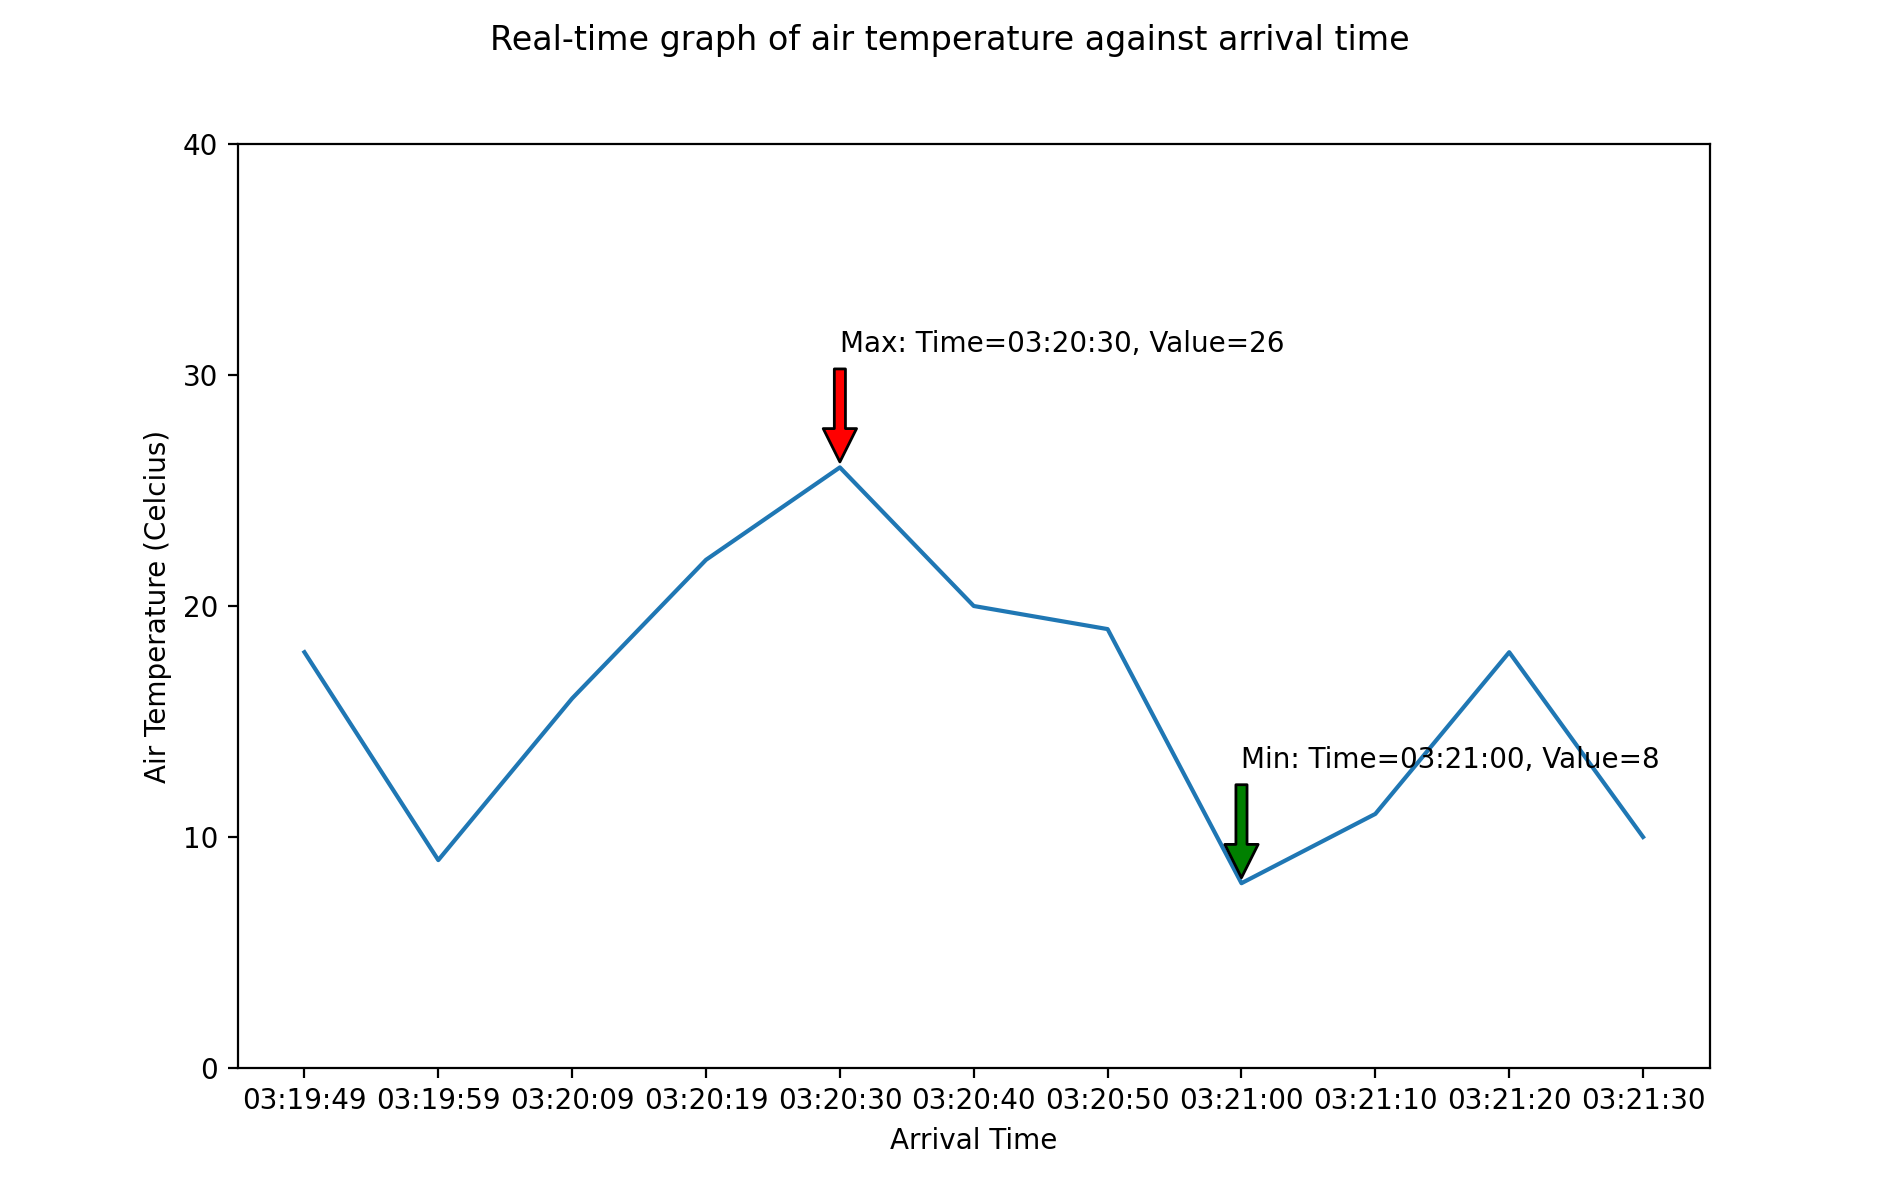

KeyboardInterrupt: 

In [3]:
# plot incoming climate stream data
consumer = connect_kafka_consumer()
fig, ax = init_plots()
consume_messages(consumer, fig, ax)

*Note that if there is existing historical data stored in the Kafka consumer, the line graph might exhibit some anomalies until the streaming data aligns. This is due to the x-coordinates of the temperature values being determined by the current arrival time when reading the messages from the topic.*

### ***2. Static data visualisation*** ###

*a.	Plot a bar chart to visualise the total number of fire records based on each hour.*

In [ ]:
# import libraries 
from pymongo import MongoClient
from pprint import pprint
import matplotlib.pyplot as plt

# display inline graphs 
%matplotlib inline

# replace with your own IP address
hostip = '192.168.1.110' 

# create connection with mongodb
client = MongoClient(hostip, 27017)

# access database 
db = client.fit3182_assignment_db

# access collection
collection = db.streaming

In [ ]:
# retrieve hotspot data from collection
result = collection.aggregate([
    {'$unwind': '$hotspots'},
    {'$project': {'_id': 0, 'hotspots.datetime': 1}}
])

# calculate total number of fire records for each hour
num_of_fires = [0] * 24
for document in result:
    hour = document['hotspots']['datetime'].hour
    num_of_fires[hour] += 1

# prepare x and y axis values
x = list(range(24))
y = num_of_fires

# plot bar chart
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xlabel('Hour')
ax.set_ylabel('Number of fire records')
ax.set_title('Total number of fire records based on each hour')
plt.show()

*Note that there should be only 5 bars at most in the chart above because it uses the streaming data instead of the historic data.*


*b. In a map visualise fire locations as markers. Use a ‘blue’ marker if the cause of the fire was ‘natural’. Otherwise, use a ‘red’ marker. Display detailed information such as air temperature, surface temperature, relative humidity, and confidence with the marker tooltip.*

In [ ]:
# import libraries 
from pymongo import MongoClient
!pip install folium
import folium

# replace with your own IP address
hostip = '192.168.1.110' 

# create connection with mongodb
client = MongoClient(hostip, 27017)

# access database 
db = client.fit3182_assignment_db

# access collection
collection = db.streaming

In [ ]:
# filter out climate document with empty hotspot data
result = collection.aggregate([
    {'$unwind': '$hotspots'},
    {'$project': {
        '_id': 0,
        'hotspots.latitude': 1,
        'hotspots.longitude': 1,
        'air_temperature_celcius': 1,
        'hotspots.surface_temperature_celcius': 1,
        'relative_humidity': 1,
        'hotspots.confidence': 1, 
        'hotspots.cause': 1
    }}
])

# compute average latitude and longitude (center coordinates of map)
result = list(result)
avg_lat = sum([x['hotspots']['latitude'] for x in result]) / len(result)
avg_long = sum([x['hotspots']['longitude'] for x in result]) / len(result)

# initialize map
fomap = folium.Map(location=[avg_lat, avg_long], zoom_start=8)

# plot a marker for each fire event
for doc in result:
    fire = doc['hotspots']
    
    # determine location of fire
    loc = (fire['latitude'], fire['longitude'])
    
    # determine color of marker
    if fire['cause'] == 'natural':
        color = 'blue'
    else:
        color = 'red'
    
    # add marker on map
    folium.Marker(
        location=loc,
        tooltip=f'''
            <li>Air Temp: {doc['air_temperature_celcius']}°C</li>
            <li>Surface Temp: {fire['surface_temperature_celcius']}°C</li>
            <li>Relative Humidity: {doc['relative_humidity']}</li>
            <li>Confidence: {fire['confidence']}</li>
        ''',
        icon=folium.Icon(color=color)
    ).add_to(fomap)
    

In [ ]:
# show map
fomap